In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_iv30drci.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[50,50,50], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


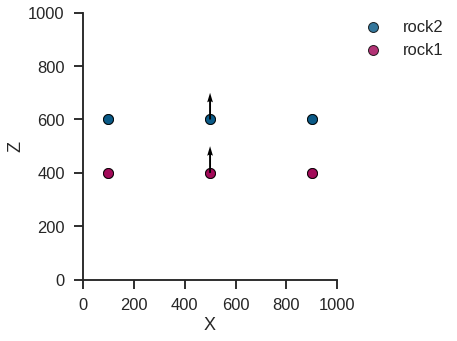

In [3]:
gp.plot.plot_data(geo_data)

We are going to make a likelihood function depending on the thickness of rock1 and 2. The most computing friendly way to do so is by adding the thickness as an attribute of the surfaces:

In [4]:
# This is the thickness of voxel
dz = geo_data.grid.regular_grid.dz
dz

20.0

In [5]:
geo_data.surfaces.add_surfaces_values([0, dz, 0], ['dz'])

,surface,series,order_surfaces,isBasement,color,id,dz
0,rock2,Default series,1,False,#015482,1,0
1,rock1,Default series,2,False,#9f0052,2,20
2,basement,Basement,1,True,#ffbe00,3,0


Now we can set the interpolator without compile theano. This will only create the graph:

In [6]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_run',
                          compile_theano=False, gradient=True)

## Compiling gempy with PyMC3

Next we need to compute a theano Op from the gempy graph:

In [7]:
import theano
import theano.tensor as T
theano.config.compute_test_value = 'ignore'

In [8]:
geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               [geo_data.interpolator.theano_graph.compute_series()[0][1][0:125000]], inline=True,
                                 on_unused_input='warn',
                                 name='geo_model')

In [24]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'ignore'
# We convert a python variable to theano.shared
input_sh = []
i = geo_data.interpolator.get_python_input_block()
for ii in i:
    input_sh.append(theano.shared(ii))

# We get the rescaling parameters:
rf = geo_data.rescaling.df.loc['values', 'rescaling factor']
centers = geo_data.rescaling.df.loc['values', 'centers']

# We create pandas groups by id to be able to modify several points at the same time:
g = geo_data.surface_points.df.groupby('id')
l = theano.shared(np.array([], dtype='float32'))

In [25]:
# PyMC3 model
theano.config.compute_test_value = 'ignore'

with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)

    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001
    

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)
    well = geo.reshape((50, 50, 50))[25,25,:]
   
    thickness = pm.Deterministic('thickness', well.sum())
    likelihood_function = pm.Normal('y', mu=thickness, sd=20, observed=120)
 #   b = pm.NUTS()
    db = pm.backends.NDArray('thickness_NUTS')
    trace = pm.sample(100, chains=1, tune=100, discard_tuned_samples=False,
                      #step =b, 
                      trace=db,
                      compute_convergence_checks=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [rock1, rock2]
100%|██████████| 200/200 [02:06<00:00,  1.52it/s]
The acceptance probability does not match the target. It is 0.9246977123216454, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [27]:
pm.save_trace(trace)

'.pymc_1.trace'

In [26]:
trace.get_values('rock1')

array([421.87482, 421.87482, 375.38644, 370.64313, 479.3073 , 479.3073 ,
       491.85437, 383.381  , 457.75006, 420.74518, 434.54056, 389.51096,
       393.68118, 393.68118, 380.03226, 392.97525, 414.17734, 441.45306,
       441.45306, 431.67816, 426.66327, 432.2432 , 441.23813, 442.38785,
       448.83337, 460.6034 , 448.6292 , 463.8007 , 458.30005, 458.30005,
       462.96103, 462.876  , 491.28558, 474.34912, 474.34912, 414.18594,
       437.16577, 450.02014, 436.05798, 429.45047, 456.14148, 464.85587,
       379.33502, 462.1837 , 435.40433, 473.66235, 470.8427 , 370.74484,
       370.74484, 368.65372, 388.5201 , 382.84286, 401.06268, 410.73166,
       435.77673, 397.06085, 407.81702, 464.94684, 459.42044, 472.07196,
       474.42746, 444.6959 , 432.7664 , 432.7664 , 440.8094 , 421.1004 ,
       419.59094, 419.59094, 410.60388, 420.523  , 425.0741 , 425.0741 ,
       434.80936, 446.2362 , 416.12357, 426.34656, 432.92404, 374.64636,
       388.179  , 390.2783 , 362.85773, 362.85773, 

In [14]:
pm.traceplot(trace)

ValueError: ("could not convert string to float: '*L\\x10D'", 'Container name "rock2"')